In [1]:
!nvidia-smi
!git clone https://github.com/Jacobiano/morpholayers.git

Thu Jul 28 09:52:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 24%   43C    P8    18W / 250W |      0MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:04:00.0 Off |                  N/A |
| 24%   44C    P8    11W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import tensorflow as tf
print(tf.__version__)
print('It should be >= 2.0.0.')
print(tf.config.experimental.list_physical_devices('GPU'))
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1], 'GPU')
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
from tensorflow.keras.callbacks import *
from tensorflow.python.keras import regularizers
import morpholayers.layers as ml

from tensorflow.keras.datasets import fashion_mnist, mnist, cifar10
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets
import pandas as pd
from PIL import Image
import seaborn as sns

2.4.1
It should be >= 2.0.0.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [3]:
class h_extrema_denoising_block_test_loss:
    def __init__(self, rmax_reg_coeff = 1., hext_coeff = 1., 
                    train_shift=0.):
        
        self.hext_coeff = hext_coeff
        self.rmax_reg_coeff = rmax_reg_coeff
        self.train_shift = train_shift

    def h_extrema_denoising_loss(self, y_true, y_pred):
        #squared_difference = tf.square(y_true - y_pred)
        #return tf.reduce_mean(squared_difference)
        y_pred = tf.cast(y_pred, tf.double)
        y_true = tf.cast(y_true, tf.double)
        #print('h_extrema_denoising_loss : y_pred.shape',y_pred.shape)
        #print('h_extrema_denoising_loss : y_true.shape',y_true.shape)
        return self.hext_coeff * tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)) #+self.train_shift))
        
    def rmax_reg_loss(self, y_true, y_pred):
        #print('rmax_reg_loss : y_pred.shape',y_pred.shape)
        #print('rmax_reg_loss : y_pred.shape',y_true.shape)
        y_pred = tf.cast(y_pred, tf.double)
        y = tf.cast(y_true, tf.double)
        y_temp = y
        #y = -tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(1,1),padding='same')(-y)
        #y = tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(1,1),padding='same')(y)
        y = kl.Lambda(ml.region_maxima_transform)(y)
        y = kl.Multiply(name="r_max_reg")([y_temp, 255.*y])
        y = tf.cast(y, tf.double)
        
        return self.rmax_reg_coeff * tf.reduce_mean(tf.math.squared_difference(y_pred,y))

    def __call__(self):
        return {"mse_denoising":  self.h_extrema_denoising_loss
                ,"r_max_reg": self.rmax_reg_loss}


In [4]:
class DatasetMNIST():
    def __init__(self, mode="classification", noise_train={"mean":0, "std":[0]}, 
                noise_val={"mean":0, "std":[0]}, reconstruction=True,
                noise=None, shuffle=True, name="",  X=None, X_noised=None, y=None,
                buffer_size=10000):
        self.noise = noise
        self.name = name
        self.noise_train = noise_train
        self.noise_val = noise_val
        self.mode = mode
        self.X = X
        self.X_noised = X_noised
        self.y = y
        self.rec = reconstruction


    def create_dataset_from_data(self, X=None, X_noised=None, y=None):
        if self.mode == "classification":
            return tf.data.Dataset.from_tensor_slices((X_noised, y))
            
        return tf.data.Dataset.from_tensor_slices((X_noised, 
                                                    {
                                            "denoising":X          
                                            }))
    def build_dataset(self, X, X_noised, y, shuffle, buffer_size, batch_size):  
        dataset = self.create_dataset_from_data(X, X_noised, y)

        dataset = dataset.cache()
        if shuffle:
            dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=True)


        return dataset
    
    def __call__(self, batch_size=256, shuffle=True, buffer_size=1000, val_prop=0.2):
        X, X_noised, y = self.X, self.X_noised, self.y
        dataset = self.build_dataset(X, X_noised, y, shuffle, buffer_size, batch_size)
        train_dataset = dataset.skip(int(len(X) * val_prop))
        val_dataset = dataset.take(int(len(X) * val_prop)) 
        
        train_dataset = train_dataset.batch(batch_size)
        train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
        
        val_dataset = val_dataset.batch(batch_size)
        val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

        return train_dataset, val_dataset

In [5]:
class DatasetMNIST_MORPHO_REG():
    def __init__(self, mode="classification", noise_train={"mean":0, "std":[0]}, 
                noise_val={"mean":0, "std":[0]}, reconstruction=True,
                noise=None, shuffle=True, name="",  X=None, X_noised=None, y=None,
                buffer_size=10000):
        self.noise = noise
        self.name = name
        self.noise_train = noise_train
        self.noise_val = noise_val
        self.mode = mode
        self.X = X
        self.X_noised = X_noised
        self.y = y
        self.rec = reconstruction


    def create_dataset_from_data(self, X=None, X_noised=None, y=None):
        if self.mode == "classification":
            return tf.data.Dataset.from_tensor_slices((X_noised, y))
            
        return tf.data.Dataset.from_tensor_slices((X_noised, {"mse_denoising":X,"r_max_reg":X}))
    def build_dataset(self, X, X_noised, y, shuffle, buffer_size, batch_size):  
        dataset = self.create_dataset_from_data(X, X_noised, y)

        dataset = dataset.cache()
        if shuffle:
            dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=True)


        return dataset
    
    def __call__(self, batch_size=256, shuffle=True, buffer_size=1000, val_prop=0.2):
        X, X_noised, y = self.X, self.X_noised, self.y
        dataset = self.build_dataset(X, X_noised, y, shuffle, buffer_size, batch_size)
        train_dataset = dataset.skip(int(len(X) * val_prop))
        val_dataset = dataset.take(int(len(X) * val_prop)) 
        
        train_dataset = train_dataset.batch(batch_size)
        train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
        
        val_dataset = val_dataset.batch(batch_size)
        val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

        return train_dataset, val_dataset

In [6]:
class Hextrema(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Hextrema, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Hextrema, self).build(input_shape)

    def call(self, x):
        return ml.h_maxima_transform([x[0], x[1]])

In [7]:
class CNN_denoising_block(tf.keras.Model):
    def __init__(self, dropout=0.1, name="CNN_denoising_rec"):       
        super(CNN_denoising_block, self).__init__(name=name)
        self.conv1 = kl.Conv2D(24, kernel_size=(3,3), padding="same",activation='relu')
        self.conv2 = kl.Conv2D(24, kernel_size=(3,3), padding="same",activation='relu')
        self.dense = kl.Dense(1, name="denoising")
        self.batchnorm1 = kl.BatchNormalization()
        self.batchnorm2 = kl.BatchNormalization()

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.batchnorm1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = tf.nn.relu(x)
        x = self.dense(x)
        return x

In [8]:
class h_extrema_denoising_block(tf.keras.Model):
    def __init__(self, dropout=0.1, name="mse_denoising"):       
        super(h_extrema_denoising_block, self).__init__(name=name)
        self.conv1 = kl.Conv2D(12, kernel_size=(3,3), padding="valid")
        self.conv2 = kl.Conv2D(1, kernel_size=(3,3), padding="valid")
        self.maxpooling = kl.MaxPool2D(pool_size=(2,2), padding="valid")
        self.dropout = kl.Dropout(dropout)
        #self.globalavgpooling = kl.GlobalAveragePooling2D(data_format='channels_last')
        self.globalavgpooling = kl.GlobalMaxPooling2D(data_format='channels_last')
        self.dense = kl.Dense(1,kernel_constraint=tf.keras.constraints.NonNeg(),name="h_denoising")
        self.h_extrema_transform = Hextrema()
        self.batchnorm1 = kl.BatchNormalization()
        self.batchnorm2 = kl.BatchNormalization()

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        #x = self.batchnorm1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        #x = self.batchnorm2(x)
        #x = tf.nn.relu(x)
        #x = self.maxpooling(x)
        x = self.globalavgpooling(x)
        #x = self.dropout(x)
        x = self.dense(x)
        #x = tf.nn.relu(x)
        h = tf.expand_dims(tf.expand_dims(x,axis=-1),axis=-1)
        return h

In [9]:
class MyRegularizer(regularizers.Regularizer):
    
    def __init__(self, regul, regul_l1, regul_log):
        self.strength = regul
        self.l1 = regul_l1
        self.log = regul_log

    def __call__(self, x):
        return  tf.cast(self.strength * tf.reduce_mean(tf.math.square(x)) + 
                        self.l1 * tf.reduce_mean(tf.math.abs(x)) + 
                        self.log * tf.reduce_mean(tf.math.log(tf.math.abs(x) + 1)), tf.double) 
    
    def get_config(self):
        return {'strength': self.strength, 'l1': self.l1, 'log': self.log}


In [10]:
class denoising_model_CNN:
    def __init__(self, n_epoch_nn = 1, train_batch_size=128, 
                test_batch_size=256, lr_nn=1e-3, size_input=(None,None,1), 
                lamb = 0., name="NO NAME SPECIFIED", noise_std=0.1,
                train_shift=0., dropout=0.1, 
                dropout_in=0.):

        # Defining Classifier Parameters
        self.n_epoch_nn = n_epoch_nn
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.lr_nn = lr_nn
        self.size_input = size_input
        self.name = name
        
        self.denoising_block = CNN_denoising_block(name="denoising", dropout=dropout)
        print("Creating architecture of ", name, "  ...")
        # neural network loss
        self.loss_nn = tf.keras.losses.MeanSquaredError()

        # --------NETWORK ARCHITECTURE ----------
        xin=kl.Input(shape=tf.TensorShape(size_input), dtype=tf.double)
        xin_noised = train_shift +xin + tf.cast(tf.abs(kl.GaussianNoise(noise_std)(tf.zeros_like(xin))), tf.double)
        
        if dropout_in >0.:
            xin_noised = kl.ReLU()(kl.GaussianDropout(dropout_in)(xin_noised))
        output_denoising=self.denoising_block(xin_noised)
        #h = self.h_extrema_denoising_block(xin_noised)
        #h = kl.ReLU(activity_regularizer=MyRegularizer(regul_l1=regul_l1, regul=regul, regul_log=regul_log))(h) 
        
        # h_origin = self.h_extrema_denoising_block(xin)
        # h_origin = kl.ReLU(activity_regularizer=MyRegularizer(regul_l1=regul_l1_or, regul=regul_or, regul_log=regul_log_or))(h_origin) 
        #output_h_denoising = Hextrema(name="h_extrema_denoising_rec")([h, xin_noised])
        #rmax_reg = kl.Lambda(ml.region_maxima_transform)(output_h_denoising)
        #rmax_reg = kl.Multiply(name="r_max_reg")([output_h_denoising, 255.*rmax_reg])

        # Models Creation
        self.nn_output_h_denoising = km.Model(xin, output_denoising, name="output_h_denoising")
        self.nn = km.Model(xin, output_denoising)
        
        #self.nn_output_h_denoising = km.Model(xin, output_h_denoising, name="output_h_denoising")
        #[output_h_denoising, rmax_reg])
        #self.nn_r_max = km.Model(xin, rmax_reg)
        #self.nn_output_h_denoising = km.Model(xin, output_h_denoising, name="output_h_denoising")
        #self.nn_h = km.Model(xin, h)

        # Optimizer, learning rate and loss choices
        self.nn_opt = tf.keras.optimizers.Adam(learning_rate=self.lr_nn)
        self.nn.compile(optimizer=self.nn_opt, 
                        loss=self.loss_nn)
        print("Done\n")


    #def predict_h(self, X):
    #    return tf.convert_to_tensor(self.nn_h.predict(X), tf.double)
    
    #def predict_H(self, X):
    #    return tf.convert_to_tensor(self.nn_H.predict(X), tf.double)

    #def predict_r_max(self, X):
    #    return tf.convert_to_tensor(self.nn_r_max.predict(X), tf.double)

    def predict_output_h_denoising(self, X):
        return tf.convert_to_tensor(self.nn.predict(X), 
                                    tf.double)
    #def predict_output_H_denoising(self, X):
    #    return tf.convert_to_tensor(self.nn_out_H.predict(X), 
    #                                tf.double)

    def train(self, train_dataset, val_dataset, verbose=1):
        if verbose == 1:
            self.nn.summary()

        #Callback definition
        CBs=[EarlyStopping(monitor='val_loss', patience=30,
                        restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.1,patience=10,
                                                min_lr=0.00001)]
        #Training the model
        self.historyi = self.nn.fit(x=train_dataset, 
                                    validation_data=val_dataset, 
                                    epochs=self.n_epoch_nn)#, callbacks=[CBs])

In [18]:
class denoising_model:
    def __init__(self, n_epoch_nn = 1, train_batch_size=128, 
                test_batch_size=256, lr_nn=1e-3, size_input=(28,28,1),#size_input=(None,None,1), 
                lamb = 0., name="NO NAME SPECIFIED", noise_std=0.1,
                reconstruction_steps=-1, hext_coeff=1., rmax_reg_coeff=1.,
                train_shift=0., regul = 0.1, regul_l1=0., regul_log=0.1, regul_or = 0.1, regul_l1_or=0., regul_log_or=0.1, dropout=0.1, 
                dropout_in=0.):

        # Defining Classifier Parameters
        self.n_epoch_nn = n_epoch_nn
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.lr_nn = lr_nn
        self.size_input = size_input
        self.name = name
        
        self.h_extrema_denoising_block = h_extrema_denoising_block(name="t", dropout=dropout)

        print("Creating architecture of ", name, "  ...")
        # neural network loss
        self.loss_nn = h_extrema_denoising_block_test_loss(
            hext_coeff=hext_coeff, rmax_reg_coeff=rmax_reg_coeff, 
            train_shift = train_shift
            )()
        
        #self.loss_nn=tf.keras.losses.MeanSquaredError() #,tf.keras.losses.BinaryCrossentropy()]

        # --------NETWORK ARCHITECTURE ----------
        xin=kl.Input(shape=tf.TensorShape(size_input), dtype=tf.double)
        xin_noised = train_shift +xin + tf.cast(tf.abs(kl.GaussianNoise(noise_std)(tf.zeros_like(xin))), tf.double)
        
        if dropout_in >0.:
            xin_noised = kl.ReLU()(kl.GaussianDropout(dropout_in)(xin_noised))
        h = self.h_extrema_denoising_block(xin_noised)
        #h = kl.ReLU(activity_regularizer=MyRegularizer(regul_l1=regul_l1, regul=regul, regul_log=regul_log))(h) 
        #h = tf.math.maxim(.01,h)
        # h_origin = self.h_extrema_denoising_block(xin)
        # h_origin = kl.ReLU(activity_regularizer=MyRegularizer(regul_l1=regul_l1_or, regul=regul_or, regul_log=regul_log_or))(h_origin) 
        output_h_denoising = Hextrema(name="mse_denoising")([h, xin_noised])
        rmax_reg = kl.Lambda(ml.region_maxima_transform)(output_h_denoising)
        #rmax_reg = kl.Multiply(name="r_max_reg")([output_h_denoising, rmax_reg])
        rmax_reg = kl.Multiply(name="r_max_reg")([output_h_denoising, 255.*rmax_reg])
        #rmax_reg = kl.MaxPool2D(pool_size=(2,2), padding="valid",name="r_max_reg")(rmax_reg)
        # Models Creation
        self.nn = km.Model(xin, [output_h_denoising, rmax_reg])
        self.nn_r_max = km.Model(xin, rmax_reg)
        self.nn_output_h_denoising = km.Model(xin, output_h_denoising, name="output_h_denoising")
        self.nn_h = km.Model(xin, h)

        # Optimizer, learning rate and loss choices
        self.nn_opt = tf.keras.optimizers.Adam(learning_rate=self.lr_nn)
        #self.nn.compile(optimizer=self.nn_opt,
        #                loss={'mse_denoising': 'mse', 'r_max_reg': 'mae'},
        #                loss_weights={'mse_denoising': 1., 'r_max_reg': 1.})
        self.nn.compile(optimizer=self.nn_opt,
                        loss=self.loss_nn)
        print("Done\n")
        self.nn.summary()

    
    def predict_h(self, X):
        return tf.convert_to_tensor(self.nn_h.predict(X), tf.double)

    
    def predict_r_max(self, X):
        return tf.convert_to_tensor(self.nn_r_max.predict(X), tf.double)

    def predict_output_h_denoising(self, X):
        return tf.convert_to_tensor(self.nn_output_h_denoising.predict(X), 
                                    tf.double)
    #def predict_H(self, X):
    #    return tf.convert_to_tensor(self.nn_H.predict(X), tf.double)


    #def predict_output_H_denoising(self, X):
    #    return tf.convert_to_tensor(self.nn_out_H.predict(X), 
    #                                tf.double)

    def train(self, train_dataset, val_dataset, verbose=1):
        #if verbose == 1:
        #    self.nn.summary()

        #Callback definition
        CBs=[EarlyStopping(monitor='val_loss', patience=30,restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.1,patience=10,
                                                min_lr=0.00001)]
        #Training the model
        self.historyi = self.nn.fit(x=train_dataset, 
                                    validation_data=val_dataset, 
                                    epochs=self.n_epoch_nn, callbacks=[CBs]
                                    )
        


In [11]:
def display_random_dataset_sample_rec(L, n = 1, rand=True, lim=(0,1), col_title = []):
    """Display a sample of size n from a dataset (X, y)

    Args:
        X (tf.Tensor): data with shape (number of data, image width, image height, channel)
        y (tf.tensor): labels
        n (int, optional): Sample size. Defaults to 1.
    """
    expand = len(L) == 1
    L = [tens.numpy() for tens in L]
    len_dataset = len(L[0])
    if rand == True:
        p = np.random.permutation(len_dataset)
        L = [elem[p] for elem in L]
    nb_subplots = len(L)
    L = np.stack(L)
    if expand: L=np.expand_dims(L, axis=0)
    
    if col_title == []:  col_title=["" for i in range(len(L))]
    
    plt.figure(figsize=(16,14))
    for j in range(1, nb_subplots+1):
        for i in range(n):
            plt.subplot(n, nb_subplots, nb_subplots*i+j)
            if L.shape[3] == 1:
                
                plt.plot(L[j-1, i,:,0,0])
            else:
                plt.axis('off')
                if lim==(0,0):
                    plt.imshow(L[j-1,i,:,:,:])
                else:
                    plt.imshow(L[j-1,i,:,:,:], clim=lim)
            if i == 0:
                plt.title(col_title[j-1])
    plt.show()

In [12]:
def test(classification_nn):
    h_pred_1_denoised=[]
    
    print("------------FOLDED NOISE-----------")
    _, (x_test, y_test) = mnist.load_data()
    X, y = x_test/255., y_test
    X, y = tf.cast(tf.convert_to_tensor(X), tf.double), tf.cast(tf.convert_to_tensor(y), tf.double)
    absi = tf.linspace(0.,1,10)
    for i in absi:
        X_pred, y_pred_true = tf.expand_dims(X, axis=3), tf.convert_to_tensor(tf.keras.utils.to_categorical(y))
        X_pred = X_pred+tf.cast(tf.abs(kl.GaussianNoise(i)(tf.zeros(shape=tf.TensorShape(X_pred.shape)), training=True)), tf.double)
        h_pred_denoised = classification_nn.predict_h(X_pred)
        h_pred_1_denoised.append(h_pred_denoised) 

    hb_denoised_mnist = tf.concat(h_pred_1_denoised, axis=1)

    plt.figure(figsize=(15, 5))
    plt.title('h boxplot for MNIST')
    plt.ylabel('h')
    plt.xlabel('Folded noise deviation')
    
    plt.grid()
    plt.boxplot(hb_denoised_mnist.numpy())
    plt.xticks([0,1,2,3,4,5,6,7,8,9,], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    plt.show()
    

    h_pred_1_denoised=[]
    
    print("------------FOLDED NOISE-----------")
    _, (x_test, y_test) = mnist.load_data()
    X, y = x_test/255., y_test
    X, y = tf.cast(tf.convert_to_tensor(X), tf.double), tf.cast(tf.convert_to_tensor(y), tf.double)
    absi = tf.linspace(0.,1,10)
    for i in absi:
        X_pred, y_pred_true = tf.expand_dims(X, axis=3), tf.convert_to_tensor(tf.keras.utils.to_categorical(y))
        X_pred = X_pred+tf.multiply(X_pred, tf.cast(tf.abs(kl.GaussianNoise(i)(tf.zeros(shape=tf.TensorShape(X_pred.shape)), training=True)), tf.double))
        h_pred_denoised = classification_nn.predict_h(X_pred)
        h_pred_1_denoised.append(h_pred_denoised) 

    hb_denoised_mnist = tf.concat(h_pred_1_denoised, axis=1)

    plt.figure(figsize=(15, 5))
    plt.title('h boxplot for MNIST')
    plt.ylabel('h')
    plt.xlabel('Folded noise deviation')
    
    plt.grid()
    plt.boxplot(hb_denoised_mnist.numpy())
    plt.xticks([0,1,2,3,4,5,6,7,8,9,], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    plt.show()


    # h_pred_1_denoised=[]

    # _, (x_test, y_test) = fashion_mnist.load_data()
    # X, y = x_test/255., y_test
    # X, y = tf.cast(tf.convert_to_tensor(X), tf.double), tf.cast(tf.convert_to_tensor(y), tf.double)
    # absi = tf.linspace(0.,1,10)
    # for i in absi:
    #     X_pred, y_pred_true = tf.expand_dims(X, axis=3), tf.convert_to_tensor(tf.keras.utils.to_categorical(y))
    #     X_pred = X_pred+tf.cast(tf.abs(kl.GaussianNoise(i)(tf.zeros(shape=tf.TensorShape(X_pred.shape)), training=True)), tf.double)
    #     h_pred_denoised = classification_nn.predict_h(X_pred)
    #     h_pred_1_denoised.append(h_pred_denoised) 

    # hb_denoised_fashion_mnist = tf.concat(h_pred_1_denoised, axis=1)

    # # plt.figure(figsize=(15, 5))
    # # plt.title('h boxplot for Fashion MNIST')
    # # plt.ylabel('h')
    # # plt.xlabel('Folded noise deviation')
    
    # # plt.grid()
    # # plt.boxplot(hb_denoised_fashion_mnist.numpy())
    # # plt.xticks([0,1,2,3,4,5,6,7,8,9,10], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    # # plt.show()
    
    # # (X, y), _ = mnist.load_data()
    # _, (X, y) = datasets.cifar10.load_data()
    # h_pred_1_denoised=[]
    # # Normalize pixel values to be between 0 and 1
    # X = tf.convert_to_tensor(X/255.)
    # X = tf.cast(tf.reduce_mean(X, axis=-1), tf.double)
    # absi = tf.linspace(0.,1,10)
    # for i in absi:
    #     X_pred, y_pred_true = tf.expand_dims(X, axis=3), tf.convert_to_tensor(tf.keras.utils.to_categorical(y))
    #     X_pred = X_pred+tf.cast(tf.abs(kl.GaussianNoise(i)(tf.zeros(shape=tf.TensorShape([10000,32,32,1])), training=True)), tf.double)
    #     h_pred_denoised = classification_nn.predict_h(X_pred)
    #     h_pred_1_denoised.append(h_pred_denoised) 

    # hb_denoised_cifar10 = tf.concat(h_pred_1_denoised, axis=1)

    # plt.figure(figsize=(15, 5))
    # plt.title('h boxplot for CIFAR10')
    # plt.ylabel('h')
    # plt.xlabel('Folded noise deviation')
    
    # plt.grid()
    # plt.boxplot(hb_denoised_cifar10.numpy())
    # plt.xticks([0,1,2,3,4,5,6,7,8,9,10], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    # plt.show()
    
    # plt.figure(figsize=(15, 5))
    # plt.boxplot(hb_denoised_fashion_mnist.numpy())
    # plt.boxplot(hb_denoised_mnist.numpy())
    # plt.boxplot(hb_denoised_cifar10.numpy())
    # plt.title('h boxplot for MNIST, Fashion MNIST and CIFAR10')
    # plt.ylabel('h')
    # plt.xlabel('Folded noise deviation')
    # plt.legend(['MNIST', 'Fashion MNIST', "CIFAR10"], loc='upper left')
    # plt.xticks([0,1,2,3,4,5,6,7,8,9], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    # plt.grid()
    # plt.show()
    
    # h_pred_1_denoised=[]

    # absi = tf.linspace(0.,1,10)
    # for i in absi:
    #     h_list = []
    #     for image in im_data:
    #         X_pred = image+tf.cast(tf.abs(kl.GaussianNoise(i)(tf.zeros(shape=tf.TensorShape(list(image.shape[0:3])+[1])), training=True)), tf.double)
    #         X_pred = tf.reduce_mean(X_pred, axis=-1)
    #         h_pred_denoised = denoising_mod.predict_h(X_pred)
    #         h_list.append(float(h_pred_denoised))
    #     h_pred_1_denoised.append(tf.expand_dims(tf.convert_to_tensor(h_list), axis=1)) 

    # hb_denoised_91image = tf.concat(h_pred_1_denoised, axis=1)

    # plt.figure(figsize=(15, 5))
    # plt.title('h boxplot for 91image')
    # plt.ylabel('h')
    # plt.xlabel('Folded noise deviation')

    # plt.grid()
    # plt.boxplot(hb_denoised_91image.numpy())
    # plt.xticks([0,1,2,3,4,5,6,7,8,9,10], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    # plt.show()
    
    # h_pred_1_denoised=[]

    # absi = tf.linspace(0.,1,10)
    # for i in absi:
    #     h_list = []
    #     for image in im_data2:
    #         X_pred = image+tf.cast(tf.abs(kl.GaussianNoise(i)(tf.zeros(shape=tf.TensorShape(list(image.shape[0:3])+[1])), training=True)), tf.double)
    #         X_pred = tf.reduce_mean(X_pred, axis=-1)
    #         h_pred_denoised = denoising_mod.predict_h(X_pred)
    #         h_list.append(float(h_pred_denoised))
    #     h_pred_1_denoised.append(tf.expand_dims(tf.convert_to_tensor(h_list), axis=1)) 

    # hb_denoised_bsd300 = tf.concat(h_pred_1_denoised, axis=1)

    # plt.figure(figsize=(15, 5))
    # plt.title('h boxplot for BSD300')
    # plt.ylabel('h')
    # plt.xlabel('Folded noise deviation')

    # plt.grid()
    # plt.boxplot(hb_denoised_bsd300.numpy())
    # plt.xticks([0,1,2,3,4,5,6,7,8,9,10], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    # plt.show()
    
    # m, f, c, q, q2 = hb_denoised_mnist.numpy(), hb_denoised_fashion_mnist.numpy(), hb_denoised_cifar10.numpy(), hb_denoised_91image.numpy(), hb_denoised_bsd300.numpy()
    # l = [0.0]*10000 + [0.1]*10000 + [0.2]*10000 + [0.3]*10000 + [0.4]*10000 + [0.5]*10000 + [0.6]*10000 + [0.7]*10000 + [0.8]*10000 + [0.9]*10000
    # l = np.array(l)
    # l2 = [0.0]*91 + [0.1]*91 + [0.2]*91 + [0.3]*91 + [0.4]*91 + [0.5]*91 + [0.6]*91 + [0.7]*91 + [0.8]*91 + [0.9]*91
    # l3 = [0.0]*300 + [0.1]*300 + [0.2]*300 + [0.3]*300 + [0.4]*300 + [0.5]*300 + [0.6]*300 + [0.7]*300 + [0.8]*300 + [0.9]*300
    # l2 = np.array(l2)
    # l3 = np.array(l3)
    # tot = np.concatenate([m.T.flatten(), f.T.flatten(), c.T.flatten(), q.T.flatten(), q2.T.flatten()], axis=0)
    # l = np.concatenate([l, l, l, l2, l3], axis=0)
    # tot = np.concatenate([np.expand_dims(tot, axis=1), np.expand_dims(l, axis=1)], axis=1)
    # lab = ["MNSIT"]*100000 + ["Fashion MNIST"]*100000 + ["CIFAR"]*100000 + ["91image"]*910 + ["BSD300"]*3000
    # lab = np.array(lab)
    # tot = np.concatenate([tot, np.expand_dims(lab, axis=1)], axis=1)
    # tot = pd.DataFrame(tot, columns=['h', 'deviation', "dataset"])
    # tot = tot.astype({'deviation': 'float32', 'h': 'float32'})
    # fig_dims = (15, 9.5)
    # fig, ax = plt.subplots(figsize=fig_dims)
    # plt.plot([1.7, 1.7], [0, 2.3], '--', lw=2, label="Training")
    # plt.legend(['Training'])
    # sns.boxplot(x="deviation", y="h",
    #             data=tot, hue="dataset", palette=["m", "g", "r", 'orange', "blue"], ax=ax)
    # plt.show()
    
    # return hb_denoised_mnist.numpy(), hb_denoised_fashion_mnist.numpy(), hb_denoised_cifar10.numpy()

In [13]:
(X_cifar, y_cifar), (X_test_cifar, y_test_cifar) = cifar10.load_data()
(X_mnist, y_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()
(X_fashion, y_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

X = {}
X["cifar"] = {"train": X_cifar, "test": X_test_cifar}
X["mnist"] = {"train": X_mnist, "test": X_test_mnist}
X["fashion"] = {"train": X_fashion, "test": X_test_fashion}

y = {"cifar": {"train": y_cifar, "test": y_test_cifar},
     "mnist": {"train": y_mnist, "test": y_test_mnist},
     "fashion": {"train": y_fashion, "test": y_test_fashion}
}

for ds in X:
    for dataset in X[ds]:
        X[ds][dataset] = tf.convert_to_tensor(X[ds][dataset]/255.)
        y[ds][dataset] = tf.convert_to_tensor(y[ds][dataset])
        if ds != "cifar":
            X[ds][dataset] = tf.expand_dims(X[ds][dataset], axis=-1)
        y[ds][dataset] = tf.keras.utils.to_categorical(y[ds][dataset])



In [14]:
Batcher  = DatasetMNIST(mode="", reconstruction=True, 
                        name="no_noise", X=X["mnist"]["train"], X_noised=X["mnist"]["train"], y=y["mnist"]["train"])
train_dataset, val_dataset = Batcher(batch_size=512)
#  hext_coeff=300, train_shift=0.001, regul=0.0, regul_l1 = 0.000, regul_log=0.00,
#                                     rmax_reg_coeff = 130., noise_std=0.1, dropout=0.2, dropout_in=0.



In [15]:
#denoising_mod_CNN = denoising_model_CNN(n_epoch_nn = 20, lr_nn=0.001, train_shift=0.00, noise_std=0.2, dropout=0.3, dropout_in=0.)

Creating architecture of  NO NAME SPECIFIED   ...
Done

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.zeros_like (TFOpLambda)      (None, None, None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, None, None, 1 0           tf.zeros_like[0][0]              
__________________________________________________________________________________________________
tf.math.abs (TFOpLambda)        (None, None, None, 1 0           gaussian_noise[0][0]             
______________________________________

94/94 [==============================] - 2s 25ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 61/200
94/94 [==============================] - 2s 26ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 62/200
94/94 [==============================] - 2s 23ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 63/200
94/94 [==============================] - 2s 25ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 64/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 65/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 66/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 67/200
94/94 [==============================] - 2s 25ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 68/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 69/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0014 - val_loss: 0.0031
Epo

Epoch 141/200
94/94 [==============================] - 2s 25ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 142/200
94/94 [==============================] - 2s 23ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 143/200
94/94 [==============================] - 2s 26ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 144/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 145/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 146/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 147/200
94/94 [==============================] - 3s 27ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 148/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 149/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 150/200
94/94 [==============================] - 2s 24ms/step - loss: 0.0012

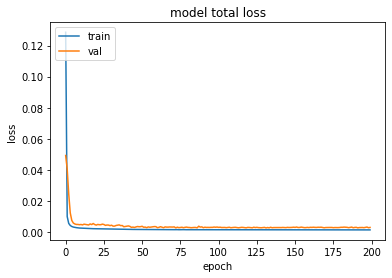

In [16]:
denoising_mod_CNN = denoising_model_CNN(n_epoch_nn = 200, lr_nn=0.001, train_shift=0.00, noise_std=0.2, dropout=0.3, dropout_in=0.,)
denoising_mod_CNN.train(train_dataset, val_dataset)

#del Batcher
#del train_dataset
#del val_dataset

plt.plot(denoising_mod_CNN.historyi.history['loss'])
plt.plot(denoising_mod_CNN.historyi.history['val_loss'])
plt.title('model total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
Batcher  = DatasetMNIST_MORPHO_REG(mode="", reconstruction=True, 
                        name="no_noise", X=X["mnist"]["train"], X_noised=X["mnist"]["train"], y=y["mnist"]["train"])
train_dataset, val_dataset = Batcher(batch_size=64)
#  hext_coeff=300, train_shift=0.001, regul=0.0, regul_l1 = 0.000, regul_log=0.00,
#                                     rmax_reg_coeff = 130., noise_std=0.1, dropout=0.2, dropout_in=0.


denoising_mod = denoising_model(n_epoch_nn = 200, lr_nn=0.001,
                                 hext_coeff=1., train_shift=0.00, regul=0., regul_l1 = 0., regul_log=0.000,
                                 rmax_reg_coeff = 1., noise_std=0.2, dropout=0.3, dropout_in=0.,
                                 regul_or = 0.00, regul_l1_or=0, regul_log_or=0)
#print('denoising_mod.nn.summary()')
#denoising_mod.nn.summary()

denoising_mod.train(train_dataset, val_dataset)
del Batcher
del train_dataset
del val_dataset


Creating architecture of  NO NAME SPECIFIED   ...
Done

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
tf.zeros_like_2 (TFOpLambda)    (None, 28, 28, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 28, 28, 1)    0           tf.zeros_like_2[0][0]            
__________________________________________________________________________________________________
tf.math.abs_2 (TFOpLambda)      (None, 28, 28, 1)    0           gaussian_noise_2[0][0]           
____________________________________

Epoch 24/200
750/750 [==============================] - 31s 42ms/step - loss: 0.0641 - mse_denoising_loss: 0.0243 - r_max_reg_loss: 0.0398 - val_loss: 0.0550 - val_mse_denoising_loss: 0.0092 - val_r_max_reg_loss: 0.0458
Epoch 25/200
750/750 [==============================] - 31s 42ms/step - loss: 0.0642 - mse_denoising_loss: 0.0243 - r_max_reg_loss: 0.0400 - val_loss: 0.0550 - val_mse_denoising_loss: 0.0091 - val_r_max_reg_loss: 0.0459
Epoch 26/200
750/750 [==============================] - 31s 42ms/step - loss: 0.0642 - mse_denoising_loss: 0.0243 - r_max_reg_loss: 0.0399 - val_loss: 0.0550 - val_mse_denoising_loss: 0.0091 - val_r_max_reg_loss: 0.0459
Epoch 27/200
750/750 [==============================] - 32s 42ms/step - loss: 0.0643 - mse_denoising_loss: 0.0243 - r_max_reg_loss: 0.0399 - val_loss: 0.0549 - val_mse_denoising_loss: 0.0092 - val_r_max_reg_loss: 0.0457
Epoch 28/200
750/750 [==============================] - 31s 42ms/step - loss: 0.0642 - mse_denoising_loss: 0.0243 - r_ma

In [21]:
hest=denoising_mod.predict_h(X['mnist']['train'][0:1000])
print(hest.shape)

(1000, 1, 1, 1)


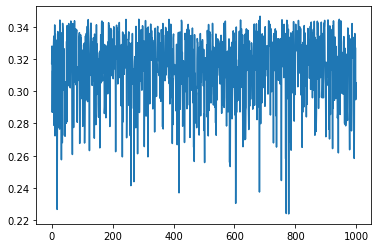

In [22]:
plt.plot(hest[:,0,0,0])

(1000, 28, 28, 1)
0.00848576877189041


(1000, 28, 28, 1)


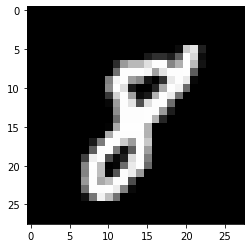

In [92]:
idx=17
I=X['mnist']['train'][idx:(idx+1)]
plt.imshow(I[0,:,:,0])

Predicted h tf.Tensor([[[[0.33167842]]]], shape=(1, 1, 1, 1), dtype=float64)


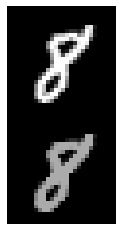

Predicted h tf.Tensor([[[[0.33865085]]]], shape=(1, 1, 1, 1), dtype=float64)


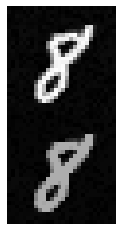

Predicted h tf.Tensor([[[[0.34562322]]]], shape=(1, 1, 1, 1), dtype=float64)


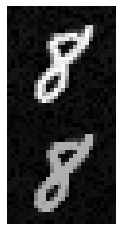

Predicted h tf.Tensor([[[[0.35259551]]]], shape=(1, 1, 1, 1), dtype=float64)


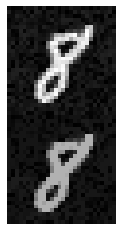

Predicted h tf.Tensor([[[[0.35956785]]]], shape=(1, 1, 1, 1), dtype=float64)


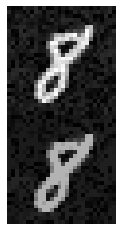

Predicted h tf.Tensor([[[[0.36654016]]]], shape=(1, 1, 1, 1), dtype=float64)


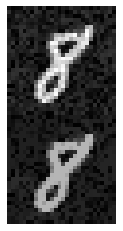

Predicted h tf.Tensor([[[[0.37351272]]]], shape=(1, 1, 1, 1), dtype=float64)


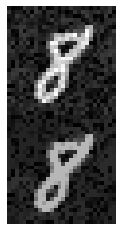

Predicted h tf.Tensor([[[[0.38048503]]]], shape=(1, 1, 1, 1), dtype=float64)


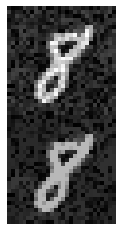

Predicted h tf.Tensor([[[[0.38745743]]]], shape=(1, 1, 1, 1), dtype=float64)


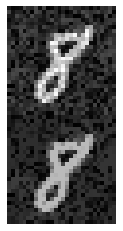

Predicted h tf.Tensor([[[[0.39442977]]]], shape=(1, 1, 1, 1), dtype=float64)


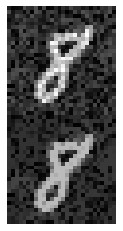

Predicted h tf.Tensor([[[[0.40140212]]]], shape=(1, 1, 1, 1), dtype=float64)


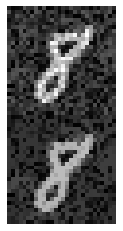

Predicted h tf.Tensor([[[[0.40837455]]]], shape=(1, 1, 1, 1), dtype=float64)


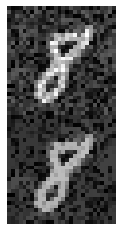

Predicted h tf.Tensor([[[[0.41534689]]]], shape=(1, 1, 1, 1), dtype=float64)


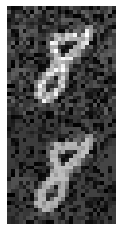

Predicted h tf.Tensor([[[[0.42231923]]]], shape=(1, 1, 1, 1), dtype=float64)


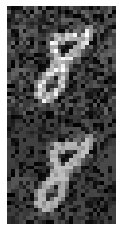

Predicted h tf.Tensor([[[[0.42929167]]]], shape=(1, 1, 1, 1), dtype=float64)


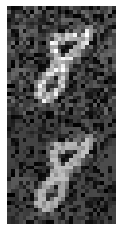

Predicted h tf.Tensor([[[[0.43626401]]]], shape=(1, 1, 1, 1), dtype=float64)


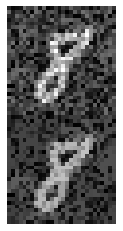

Predicted h tf.Tensor([[[[0.44323638]]]], shape=(1, 1, 1, 1), dtype=float64)


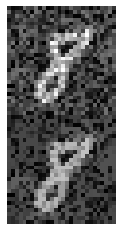

Predicted h tf.Tensor([[[[0.45020884]]]], shape=(1, 1, 1, 1), dtype=float64)


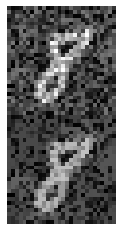

Predicted h tf.Tensor([[[[0.45718122]]]], shape=(1, 1, 1, 1), dtype=float64)


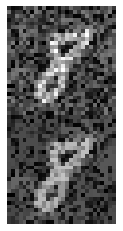

Predicted h tf.Tensor([[[[0.46415344]]]], shape=(1, 1, 1, 1), dtype=float64)


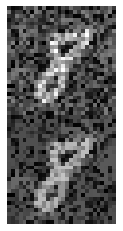

Predicted h tf.Tensor([[[[0.33167842]]]], shape=(1, 1, 1, 1), dtype=float64)


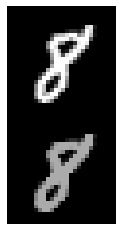

Predicted h tf.Tensor([[[[0.34142298]]]], shape=(1, 1, 1, 1), dtype=float64)


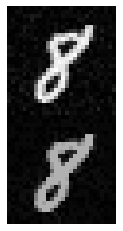

Predicted h tf.Tensor([[[[0.3511675]]]], shape=(1, 1, 1, 1), dtype=float64)


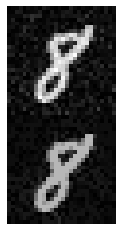

Predicted h tf.Tensor([[[[0.36092532]]]], shape=(1, 1, 1, 1), dtype=float64)


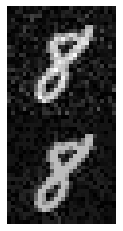

Predicted h tf.Tensor([[[[0.37132478]]]], shape=(1, 1, 1, 1), dtype=float64)


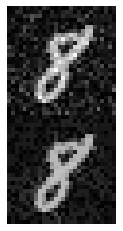

Predicted h tf.Tensor([[[[0.38213241]]]], shape=(1, 1, 1, 1), dtype=float64)


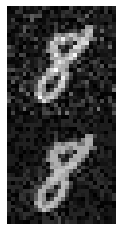

Predicted h tf.Tensor([[[[0.3929401]]]], shape=(1, 1, 1, 1), dtype=float64)


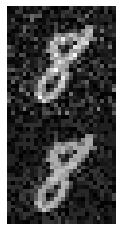

Predicted h tf.Tensor([[[[0.40382248]]]], shape=(1, 1, 1, 1), dtype=float64)


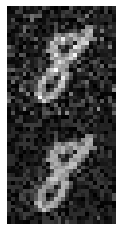

Predicted h tf.Tensor([[[[0.41523394]]]], shape=(1, 1, 1, 1), dtype=float64)


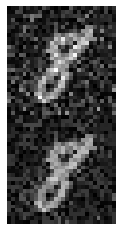

Predicted h tf.Tensor([[[[0.42810979]]]], shape=(1, 1, 1, 1), dtype=float64)


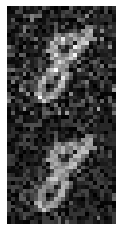

Predicted h tf.Tensor([[[[0.44098532]]]], shape=(1, 1, 1, 1), dtype=float64)


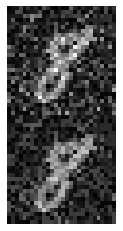

Predicted h tf.Tensor([[[[0.45386103]]]], shape=(1, 1, 1, 1), dtype=float64)


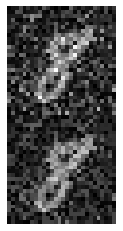

Predicted h tf.Tensor([[[[0.46680817]]]], shape=(1, 1, 1, 1), dtype=float64)


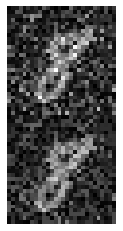

Predicted h tf.Tensor([[[[0.47980788]]]], shape=(1, 1, 1, 1), dtype=float64)


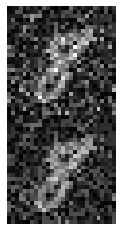

Predicted h tf.Tensor([[[[0.49574754]]]], shape=(1, 1, 1, 1), dtype=float64)


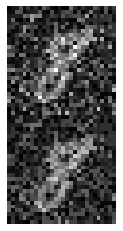

Predicted h tf.Tensor([[[[0.51184058]]]], shape=(1, 1, 1, 1), dtype=float64)


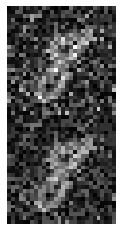

Predicted h tf.Tensor([[[[0.52793366]]]], shape=(1, 1, 1, 1), dtype=float64)


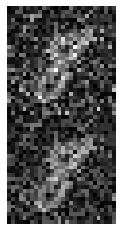

Predicted h tf.Tensor([[[[0.54402685]]]], shape=(1, 1, 1, 1), dtype=float64)


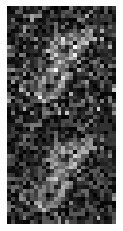

Predicted h tf.Tensor([[[[0.56011987]]]], shape=(1, 1, 1, 1), dtype=float64)


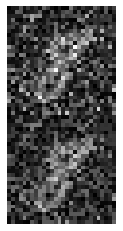

Predicted h tf.Tensor([[[[0.57630318]]]], shape=(1, 1, 1, 1), dtype=float64)


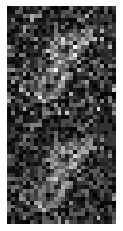

In [94]:
idx=17
NOISE=np.random.random((1,28,28,1))
for ii,i in enumerate(np.linspace(0,1,20)):
    I=X['mnist']['train'][idx:(idx+1)]+(NOISE*i)
    Hest=denoising_mod.predict_output_h_denoising(I)
    print('Predicted h',denoising_mod.predict_h(I))
    res=tf.reduce_mean(tf.math.squared_difference(Hest,I))
    Rest=denoising_mod.predict_r_max(I)
    #Z=X['mnist']['train'][idx][:,:,0]
    plt.gray()
    #plt.imshow(I[0,:,:,0])
    #plt.axis('off')
    #plt.show()
    #plt.imshow(np.concatenate([I[0,:,:,0],Hest[0][:,:,0]],axis=-1))
    #plt.axis('off')
    #plt.show()
    #print(tf.reduce_max(Hest[0][:,:,0]))
    #print(tf.reduce_min(Hest[0][:,:,0]))
    plt.imshow(np.concatenate([I[0,:,:,0],Hest[0][:,:,0]],axis=0)) #,Rest[0][:,:,0]
    plt.axis('off')
    plt.show()
    plt.imsave('FigsAyoub/UniformTwoNoise'+str(ii)+'.png',np.concatenate([I[0,:,:,0],Hest[0][:,:,0]],axis=0))
    plt.imsave('FigsAyoub/UniformRMAXTwoNoise'+str(ii)+'.png',np.concatenate([I[0,:,:,0],Hest[0][:,:,0],Rest[0][:,:,0]],axis=0))
    
    #print(tf.reduce_max(Rest[0][:,:,0]))
    #print(tf.reduce_min(Rest[0][:,:,0]))

    
NOISE=np.abs(np.random.randn(1,28,28,1))
for ii,i in enumerate(np.linspace(0,1,20)):
    I=X['mnist']['train'][idx:(idx+1)]+(NOISE*i)
    Hest=denoising_mod.predict_output_h_denoising(I)
    print('Predicted h',denoising_mod.predict_h(I))
    res=tf.reduce_mean(tf.math.squared_difference(Hest,I))
    Rest=denoising_mod.predict_r_max(I)
    #Z=X['mnist']['train'][idx][:,:,0]
    plt.gray()
    #plt.imshow(I[0,:,:,0])
    #plt.axis('off')
    #plt.show()
    #plt.imshow(np.concatenate([I[0,:,:,0],Hest[0][:,:,0]],axis=-1))
    #plt.axis('off')
    #plt.show()
    #print(tf.reduce_max(Hest[0][:,:,0]))
    #print(tf.reduce_min(Hest[0][:,:,0]))
    plt.imshow(np.concatenate([I[0,:,:,0],Hest[0][:,:,0]],axis=0)) #,Rest[0][:,:,0]
    plt.axis('off')
    plt.show()
    plt.imsave('FigsAyoub/GaussianTwoNoise'+str(ii)+'.png',np.concatenate([I[0,:,:,0],Hest[0][:,:,0]],axis=0))
    plt.imsave('FigsAyoub/GaussianRMAXTwoNoise'+str(ii)+'.png',np.concatenate([I[0,:,:,0],Hest[0][:,:,0],Rest[0][:,:,0]],axis=0))
    
    #print(tf.reduce_max(Rest[0][:,:,0]))
    #print(tf.reduce_min(Rest[0][:,:,0]))


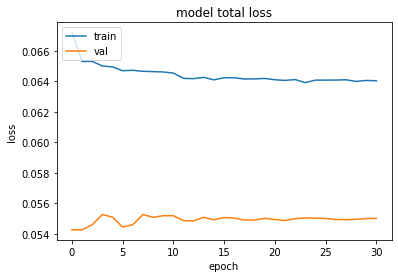

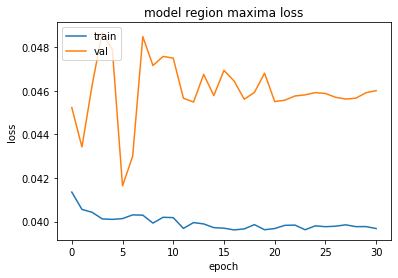

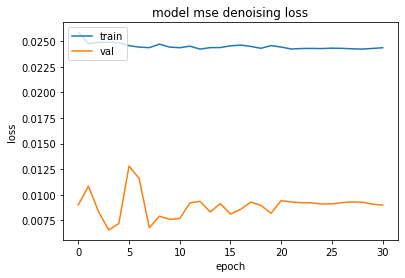

In [27]:
plt.plot(denoising_mod.historyi.history['loss'])
plt.plot(denoising_mod.historyi.history['val_loss'])
plt.title('model total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(denoising_mod.historyi.history['r_max_reg_loss'])
plt.plot(denoising_mod.historyi.history['val_r_max_reg_loss'])
plt.title('model region maxima loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(denoising_mod.historyi.history['mse_denoising_loss'])
plt.plot(denoising_mod.historyi.history['val_mse_denoising_loss'])
plt.title('model mse denoising loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.gray()
for database in ['fashion','mnist']:
    print(database)
    
    ##################################################
    ## MODEL 0: CNN DENOISING without AUGMENTATION
    denoising_mod_CNN.denoising_block.trainable=False
    loss =tf.losses.CategoricalCrossentropy()
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    xin=kl.Input(shape=tf.TensorShape((28,28,1)), dtype=tf.double)
    xin_noised = xin
    denoise = denoising_mod_CNN.nn_output_h_denoising(xin_noised)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(denoise)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(x)
    x = kl.MaxPooling2D(pool_size=(3,3))(x)
    x = kl.Dropout(0.5)(x)
    x = kl.Flatten()(x)
    output = kl.Dense(10,activation="softmax", name='classification')(x)
    model_CNN_CNN = tf.keras.Model(xin, output)
    model_CNN_CNN.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    hist_CNN_CNN = model_CNN_CNN.fit(x=X[database]['train'], y=y[database]['train'], batch_size=256, validation_split=0.2, epochs=50)

    
    ##################################################
    ## MODEL 0: CNN DENOISING with AUGMENTATION
    denoising_mod_CNN.denoising_block.trainable=False
    loss =tf.losses.CategoricalCrossentropy()
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    xin=kl.Input(shape=tf.TensorShape((28,28,1)), dtype=tf.double)
    #xin_noised = 0.1 + kl.GaussianNoise(0.1)(xin)
    xin_noised = kl.GaussianNoise(0.1)(xin)
    denoise = denoising_mod_CNN.nn_output_h_denoising(xin_noised)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(denoise)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(x)
    x = kl.MaxPooling2D(pool_size=(3,3))(x)
    x = kl.Dropout(0.5)(x)
    x = kl.Flatten()(x)
    output = kl.Dense(10,activation="softmax", name='classification')(x)
    model_CNN_CNN_NOISE = tf.keras.Model(xin, output)
    model_CNN_CNN_NOISE.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    hist_CNN_CNN_NOISE = model_CNN_CNN_NOISE.fit(x=X[database]['train'], y=y[database]['train'], batch_size=256, validation_split=0.2, epochs=50)
 

    
    
    ##################################################
    ## MODEL 1: PROPOSED without AUGMENTATION
    denoising_mod.nn_output_h_denoising.trainable=False
    loss =tf.losses.CategoricalCrossentropy()
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    xin=kl.Input(shape=tf.TensorShape((28,28,1)), dtype=tf.double)
    xin_noised = xin
    denoise = denoising_mod.nn_output_h_denoising(xin_noised)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(denoise)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(x)
    x = kl.MaxPooling2D(pool_size=(3,3))(x)
    x = kl.Dropout(0.5)(x)
    x = kl.Flatten()(x)
    output = kl.Dense(10,activation="softmax", name='classification')(x)
    model_H = tf.keras.Model(xin, output)
    model_H.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    hist = model_H.fit(x=X[database]['train'], y=y[database]['train'], batch_size=256, validation_split=0.2, epochs=50)
    
    ##################################################
    ##MODEL 2: PROPOSED with AUGMENTATION
    
    denoising_mod.nn_output_h_denoising.trainable=False
    loss =tf.losses.CategoricalCrossentropy()
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    xin=kl.Input(shape=tf.TensorShape((28,28,1)), dtype=tf.double)
    #xin_noised = 0.1 + kl.GaussianNoise(0.1)(xin)
    xin_noised = kl.GaussianNoise(0.1)(xin)
    denoise = denoising_mod.nn_output_h_denoising(xin_noised)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(denoise)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(x)
    x = kl.MaxPooling2D(pool_size=(3,3))(x)
    x = kl.Dropout(0.5)(x)
    x = kl.Flatten()(x)
    output = kl.Dense(10,activation="softmax", name='classification')(x)
    model_H_NOISE = tf.keras.Model(xin, output)
    model_H_NOISE.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    hist_NOISE = model_H_NOISE.fit(x=X[database]['train'], y=y[database]['train'], batch_size=256, validation_split=0.2, epochs=50)

    ##################################################
    ##MODEL 3: CLASSICAL CNN without augmentation
    xin=kl.Input(shape=tf.TensorShape((28,28,1)), dtype=tf.double)
    xin_noised = xin
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(xin_noised)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(x)
    x = kl.MaxPooling2D(pool_size=(3,3))(x)
    x = kl.Dropout(0.5)(x)
    x = kl.Flatten()(x)
    output = kl.Dense(10,activation="softmax", name='classification')(x)
    model_CNN = tf.keras.Model(xin, output)
    model_CNN.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    hist_CNN = model_CNN.fit(x=X[database]['train'], y=y[database]['train'], batch_size=256, validation_split=0.2, epochs=50)

    ##################################################
    ##MODEL 4: CLASSICAL CNN with augmentation
    xin=kl.Input(shape=tf.TensorShape((28,28,1)), dtype=tf.double)
    xin_noised = kl.GaussianNoise(0.1)(xin)
    #xin_noised = 0.1 + kl.GaussianNoise(0.1)(xin)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(xin_noised)
    x = kl.Conv2D(32, kernel_size=(3,3), activation='relu')(x)
    x = kl.MaxPooling2D(pool_size=(3,3))(x)
    x = kl.Dropout(0.5)(x)
    x = kl.Flatten()(x)
    output = kl.Dense(10,activation="softmax", name='classification')(x)
    model_CNN_NOISE = tf.keras.Model(xin, output)
    model_CNN_NOISE.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    hist_CNN_NOISE = model_CNN_NOISE.fit(x=X[database]['train'], y=y[database]['train'], batch_size=256, validation_split=0.2, epochs=50)

    print('Staring comparison on noise images')
    for noise_type in ['uniform','normal']:
        accCNN_CNN=[]
        accCNN_CNN_NOISE=[]
        accCNN=[]
        accCNN_NOISE=[]
        accH=[]
        accH_NOISE=[]    
        for i in tf.linspace(0,1,20):
            i = tf.cast(i, tf.float32)
            # X_pred = X["mnist"]["test"]+tf.multiply(X["mnist"]["test"], tf.cast(tf.abs(kl.GaussianNoise(i)(tf.zeros(shape=tf.TensorShape(X["mnist"]["test"].shape)), training=True)), tf.double))
            if noise_type=='uniform':
                X_pred = X[database]["test"] + tf.cast(tf.random.uniform(X[database]["test"].shape, 0., i), tf .double)
            elif noise_type=='normal':
                X_pred = X[database]["test"] + tf.cast(tf.random.normal(X[database]["test"].shape, 0., i), tf .double)
            plt.imshow(X_pred[0,:,:,0])
            plt.axis('off')
            plt.show()
            accCNN_CNN.append(model_CNN_CNN.evaluate(X_pred, y[database]["test"], batch_size=512, verbose=0)[1])
            accCNN_CNN_NOISE.append(model_CNN_CNN_NOISE.evaluate(X_pred, y[database]["test"], batch_size=512, verbose=0)[1])
            accCNN.append(model_CNN.evaluate(X_pred, y[database]["test"], batch_size=512, verbose=0)[1])
            accCNN_NOISE.append(model_CNN_NOISE.evaluate(X_pred, y[database]["test"], batch_size=512, verbose=0)[1])
            accH.append(model_H.evaluate(X_pred, y[database]["test"], batch_size=512, verbose=0)[1])
            accH_NOISE.append(model_H_NOISE.evaluate(X_pred, y[database]["test"], batch_size=512, verbose=0)[1])
        np.save(noise_type+database+'accCNN_CNN',accCNN_CNN)
        np.save(noise_type+database+'accCNN_CNN_NOISE',accCNN_CNN_NOISE)
        np.save(noise_type+database+'accCNN',accCNN)
        np.save(noise_type+database+'accCNN_NOISE',accCNN_NOISE)
        np.save(noise_type+database+'accCNNH',accH)
        np.save(noise_type+database+'accCNNH_NOISE',accH_NOISE)
    #plt.savefig('FigsAyoub/'+database+'_COMPARISON_RESULT.pgf')
    
    

In [ ]:
for save_fig in [False,True]:
    if save_fig:
        import matplotlib
        matplotlib.use("pgf")
        matplotlib.rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })
    database_list=['mnist','fashion']
    database_name=['MNIST','FASHION MNIST']
    noise_type=['uniform','normal']
    for noisename in noise_type:
        for database,databasename in zip(database_list,database_name):
            accCNN_CNN=np.load(noisename+database+'accCNN_CNN.npy')
            accCNN_CNN_NOISE=np.load(noisename+database+'accCNN_CNN_NOISE.npy')
            accCNN=np.load(noisename+database+'accCNN.npy')
            accCNN_NOISE=np.load(noisename+database+'accCNN_NOISE.npy')
            accH=np.load(noisename+database+'accCNNH.npy')
            accH_NOISE=np.load(noisename+database+'accCNNH_NOISE.npy')
            plt.figure()
            plt.plot(np.linspace(0,1,20),accCNN,label='CNN')
            plt.plot(np.linspace(0,1,20),accCNN_NOISE,label='CNN Augmentation')
            plt.plot(np.linspace(0,1,20),accCNN_CNN,label='CNN_CNN')
            plt.plot(np.linspace(0,1,20),accCNN_CNN_NOISE,label='CNN_CNN Augmentation')
            plt.plot(np.linspace(0,1,20),accH,label='HMAX CNN')
            plt.plot(np.linspace(0,1,20),accH_NOISE,label='HMAX CNN Augmentation')
            plt.xlim([0,1])
            if save_fig:
                print('.')
            else:
                plt.title(databasename+' '+noisename+' noise')
            plt.xlabel('Noise Level')
            plt.ylabel('Accuracy in Test')
            plt.grid()
            plt.legend()
            if save_fig:
                plt.savefig('FigsEMD/Ayoub'+database+noisename+'.pgf')
            else:
                plt.show()

In [95]:
pwd

'/home/velasco/tf2'